# Regularized Linear Regression and Bias v.s. Variance

Stanford CS229 - Machine Learning by Andrew Ng. Programming exercise 5.

Please check out [the repository on GitHub](https://github.com/rickwierenga/CS229-Python/). If you spot any mistakes or inconcistencies, please create an issue. For questions you can find me on Twitter: [@rickwierenga](https://twitter.com/rickwierenga). Starring the project on GitHub means a ton to me!

In [357]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.optimize import minimize
%matplotlib inline

# PyLab is a convenience module that bulk imports matplotlib.pyplot (for plotting) 
# and NumPy (for Mathematics and working with arrays) in a single name space. Although many examples use PyLab, 
# it is no longer recommended

## Regularized Linear Regression

---
In the first half of the exercise, you will implement regularized linear regres- sion to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diag- nostics of debugging learning algorithms and examine the effects of bias v.s. variance.

Start by loading the data.

In [358]:
import scipy.io as sio

# Load data
data = sio.loadmat("ex5data1.mat") # loads matlab formated file as dictionary
X = data["X"]
m, n = X.shape # 12, 1
y = data["y"].reshape(m) # y.shape is (12, )
Xval = data['Xval']
mval, nval = Xval.shape
yval = data['yval'].reshape(mval)

Xtest = data['Xtest']
mtest, ntest = Xtest.shape
ytest = data['ytest'].reshape(mtest)


# Add bias to X
X = np.hstack((np.ones((m, 1)), X)) # np.hstack concatenates duz druge ose 
Xval = np.hstack((np.ones((mval, 1)), Xval))
Xtest = np.hstack((np.ones((mtest, 1)), Xtest))

### Visualising the data

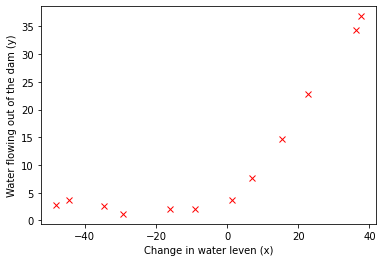

In [359]:
plt.plot(X[:, 1], y, 'rx')
plt.xlabel('Change in water leven (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

Recall the cost function for regularized linear regression: 

$$J(\theta) = \frac{1}{2m}(\displaystyle\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2) + \frac{\lambda}{2m}\displaystyle\sum_{j=1}^{n}{\theta_j}^2$$

**Exercise**: Write a regularized vectorized linear regression function.

In [360]:
def linear_reg_cost_function(theta, X, y, _lambda):
    m = len(y)
    
    cost = 1 / (2 * m) * np.sum(np.square(X @ theta - y))
    
    
    # NOTE: We don't regularize the bias term theta[0]
    regularization = _lambda / (2 * m) * np.sum(np.square(theta[1:])) 
    
    return cost + regularization

According to the exercise, using ones for theta should return 303.993 as intial cost.

In [361]:
initial_theta = np.ones(2)
linear_reg_cost_function(initial_theta, X, y, _lambda=1)

303.9931922202643

### Regularized linear regression gradient

The partial derrivatives for $\theta_j$:

$$\frac{\delta J(\theta)}{\delta\theta_j} = \frac{1}{m}\displaystyle\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}$$ for $j=0$

$$\frac{\delta J(\theta)}{\delta\theta_j} = (\frac{1}{m}\displaystyle\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_i^{(i)}) + \frac{\lambda}{m}\theta_j$$ for $j\geqslant 1$

Vectorized: 

$$\frac{\delta J(\theta)}{\delta\theta_j} = \frac{1}{m} \cdot X^T \cdot (X\theta - \vec{y}) $$

**Exercise**: Find the partial derrivatives of $J(\theta)$. Your code should not contain any loops.

In [362]:
def compute_gradient(theta, X, y, _lambda):
    hx = X @ theta
    cost = (1/m) * X.T @ (hx - y)
    regularization = (_lambda/m) * np.concatenate(([0], theta[1:]))
    return cost + regularization

You should get the following values: $\begin{bmatrix}-15.30 && 598.250 \end{bmatrix}$.

In [363]:
compute_gradient(initial_theta, X, y, _lambda=1)

array([-15.30301567, 598.25074417])

### Training the mdoel
Now we can train the model using `scipy.optimize.minimize`. In this implementation, we set $\lambda$ to 0.

In [364]:
_lambda = 0
args = (X, y, _lambda)
result = minimize(linear_reg_cost_function, initial_theta, args=args,
                  method='CG', jac=compute_gradient,
                  options={'maxiter': 50, 'disp': True})
theta = result.x
theta

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


array([13.08790734,  0.36777925])

### Visualize the found $\theta$

Althought the found value is not a good value, it's the best conjugate gradient could find using our model.

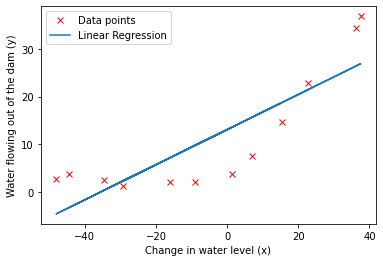

In [365]:
plt.plot(X[:, 1], y, 'rx', label = 'Data points')
plt.plot(X[:, 1], X @ theta, label = 'Linear Regression')
plt.legend()
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

## Bias Variance
Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

### Learning Curves
You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size.

This model has a high bias problem.

**Exercise**: Implement the learning curve function.

In [366]:
# Note : If you're using your cost function (linear_reg_cost_function)
#        to compute the training and cross validation error, you should
#        call the function with the lamdba argument set to 0.
#        Do note that you will still need to use lamdba when running the
#        training to obtain the theta parameters.

def learning_curve(X, y, Xval, yval, _lambda):
    """ Get the learning curves for each value of m
    
    Returns:
    :error_train: The training error of the dataset until i
    :error_val:   The error of the _entire_ cross validation set
    """
    m, n = X.shape
    error_train = np.zeros((m, 1))
    error_val   = np.zeros((m, 1))
    
    for i in range(1, m+1):
        args = (X[:i, :], y[:i], _lambda) # _lambda = 0, don't include regularization f0r training
        result = minimize(linear_reg_cost_function, initial_theta, args=args,
                         method='CG', jac = compute_gradient, options={'maxiter': 50, 'disp': False})
        theta = result.x
        
        error_train[i-1, :] = linear_reg_cost_function(theta, X[:i, :], y[:i], _lambda = 0)
        error_val[i-1, :] = linear_reg_cost_function(theta, Xval, yval, _lambda = 0)
        
    
    return error_train, error_val

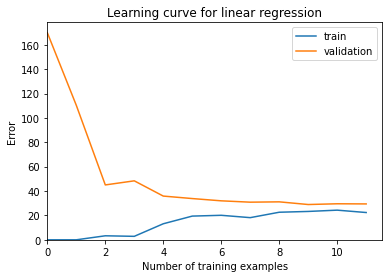

In [368]:
error_train, error_val = learning_curve(X, y, Xval, yval, _lambda)
plt.plot(error_train, label='train')
plt.plot(error_val, label='validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Learning curve for linear regression')
plt.xlim(0, )
plt.ylim(0, )
plt.legend()

## Polynomial Regression
The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features.

**Exercise**: Implement the function that maps the original training set X of size $m \times 1$ into its higher powers. Specifically, when a training set X of size m × 1 is passed into the function, the function should return a $m \times p$ matrix.

In [369]:
def polynomial_features(X, p):
    
    X_poly = np.zeros((X.size, p))

    # ===================== Your Code Here =====================
    # Instructions : Given a vector X, return a matrix X_poly where the p-th
    #                column of X contains the values of X to the p-th power.
    #

    P = np.arange(1, p + 1)

    X_poly = X.reshape((X.size, 1)) ** P
    
    return X_poly

Remember feature scaling:

$$X := \frac{X - \mu}{\sigma}$$

Where $\mu$ is the average value of $X$ and $\sigma$ is the standard deviation.

**Exercise**: Implement feature scaling.

In [370]:
def scale_features(X):
    mu = np.mean(X, 0)
    sigma = np.std(X, 0, ddof = 1)
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma

Add polynomial features to $X$ and normalize it.

In [371]:
p = 8

X_poly = polynomial_features(X[:, 1:], p) # ignore the bias column when adding polynomial features.
#print(X_poly.shape)
X_poly, mu, sigma = scale_features(X_poly)
X_poly = np.hstack((np.ones((m, 1)), X_poly))

# X_val
X_val_poly = polynomial_features(Xval[:, 1:], p) # ignore the bias column when adding polynomial features.
X_val_poly = (X_val_poly - mu) / sigma
X_val_poly = np.hstack((np.ones((X_val_poly.shape[0], 1)), X_val_poly))

# X_test
X_test_poly = polynomial_features(Xtest[:, 1:], p) # ignore the bias column when adding polynomial features.
X_test_poly = (X_test_poly - mu) / sigma
X_test_poly = np.hstack((np.ones((X_test_poly.shape[0], 1)), X_test_poly))

### Learning polynomial regression

This example shows the learning curve and fit without regularization (high variance).

In [388]:
_lambda = 1
args = (X_poly, y, _lambda)
initial_theta = np.ones(p+1)
result = minimize(linear_reg_cost_function, initial_theta, args=args,
                  method='CG', jac=compute_gradient,
                  options={'maxiter': 1000, 'disp': True})
theta = result.x

Optimization terminated successfully.
         Current function value: 7.268148
         Iterations: 31
         Function evaluations: 54
         Gradient evaluations: 54


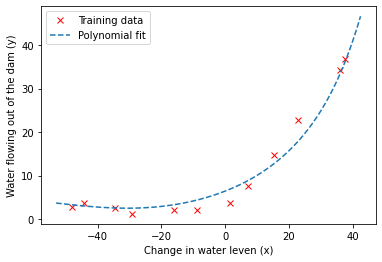

In [389]:
# Plot training data
plt.plot(X[:,1], y, 'rx', label='Training data')

# Plot polynomial fit
space = np.array(np.arange(np.min(X) - 5, np.max(X) + 5, 0.05)).reshape((1912, 1))
X_poly_plt = polynomial_features(space, p)
X_poly_plt = (X_poly_plt - mu) / sigma
X_poly_plt = np.hstack((np.ones((X_poly_plt.shape[0], 1)), X_poly_plt))
plt.plot(space, X_poly_plt @ theta, '--', label='Polynomial fit')

# Plot
plt.legend()
plt.xlabel('Change in water leven (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

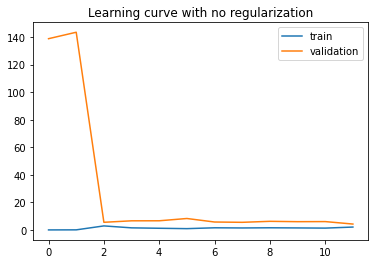

In [391]:
error_train, error_val = learning_curve(X_poly, y, X_val_poly, yval, _lambda)
plt.plot(error_train, label='train')
plt.plot(error_val, label='validation')
plt.title('Learning curve with no regularization')
plt.legend()

### Adjusting the regularization parameter

In [400]:
def plot_regularization(_lambda):
    """ Plot the fit and learning curve for a regularization parameter _lambda """
    
    # 1. Fit
    
    # Find theta
    args = (X_poly, y, _lambda)
    initial_theta = np.ones(p+1)
    result = minimize(linear_reg_cost_function, initial_theta, args=args,
                      method='CG', jac=compute_gradient,
                      options={'maxiter': 1000, 'disp': False})
    theta = result.x
    
    # Plot training data
    plt.plot(X[:,1], y, 'rx', label='Training data')

    # Plot polynomial fit
    space = np.array(np.arange(np.min(X) - 5, np.max(X) + 5, 0.05)).reshape((1912, 1))
    X_poly_plt = polynomial_features(space, p)
    X_poly_plt = (X_poly_plt - mu) / sigma
    X_poly_plt = np.hstack((np.ones((X_poly_plt.shape[0], 1)), X_poly_plt))
    plt.plot(space, X_poly_plt @ theta, '--', label='Polynomial fit')

    # Plot
    plt.legend()
    plt.xlabel('Change in water leven (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.show()
    
    
    # 2. Learning curve
    
    # Plot learning curve
    error_train, error_val = learning_curve(X_poly, y, X_val_poly, yval, _lambda)
    plt.plot(error_train, label='train')
    plt.plot(error_val, label='validation')
    plt.title('Learning curve with no regularization')
    plt.legend()
    
    plt.show()

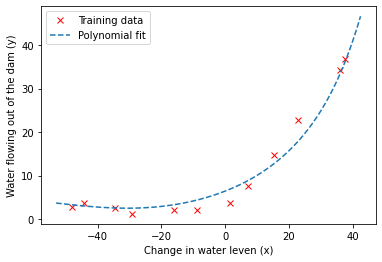

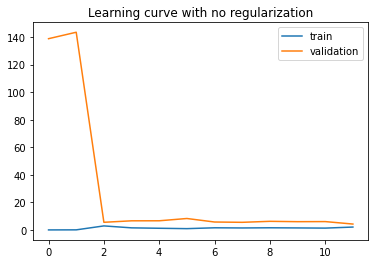

In [401]:
# Good regularization
plot_regularization(1)

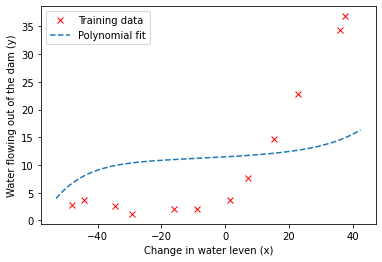

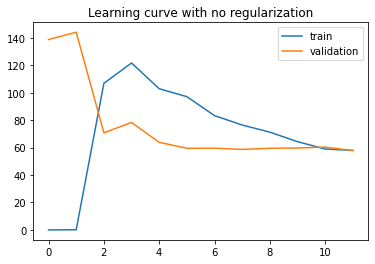

In [403]:
# (Way) too much regularization
plot_regularization(100)

In [404]:
def error_vs_lambda(_lambda_array):
    
    error_train = np.empty(len(_lambda_array))
    error_val = np.empty(len(_lambda_array))
    
    i = 0
    
    for _lambda in _lambda_array:
        # Find theta
        args = (X_poly, y, _lambda)
        initial_theta = np.ones(p+1)
        result = minimize(linear_reg_cost_function, initial_theta, args=args,
                          method='CG', jac=compute_gradient,
                          options={'maxiter': 1000, 'disp': False})
        theta = result.x
        
        # Find error_train and error_val
        error_train[i] = linear_reg_cost_function(theta, X_poly, y, _lambda = 0)
        error_val[i] = linear_reg_cost_function(theta, X_val_poly, yval, _lambda)
        
        i += 1
    
    plt.plot(_lambda_array, error_train, label = 'Train')
    plt.plot(_lambda_array, error_val, label = 'Cross validation')
    plt.xlabel('lambda')
    plt.ylabel('Error')
    plt.show()

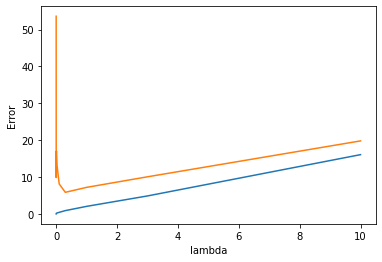

In [406]:
_lambda_array = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
error_vs_lambda(_lambda_array)

In [407]:
error_test = linear_reg_cost_function(theta, X_test_poly, ytest, _lambda = 0.3)
print(f'The test error is: {error_test:.2f}.')

The test error is: 3.62.


In [408]:
def random_learning_curve(X_poly, y, X_val_poly, yval, _lambda = 0.01, avg_num = 50):
    
    m, n = X_poly.shape
    error_train = np.zeros((m, 1))
    error_val   = np.zeros((m, 1))
    
    for i in range(1, m + 1):
    
        for _ in range(avg_num):
            
            indexes = np.random.randint(X_poly.shape[0], size = i) 
            
            args = (X_poly[indexes, :], y[indexes], _lambda) # _lambda = 0, don't include regularization for training
            result = minimize(linear_reg_cost_function, initial_theta, args=args,
                             method='CG', jac = compute_gradient, options={'maxiter': 50, 'disp': False})
            theta = result.x

            error_train[i-1, :] += linear_reg_cost_function(theta, X_poly[indexes, :], y[indexes], _lambda)
            
            indexes = np.random.randint(X_val_poly.shape[0], size = i) 
            
            error_val[i-1, :] += linear_reg_cost_function(theta, X_val_poly[indexes, :], yval[indexes], _lambda)
        
    error_train /= avg_num
    error_val /= avg_num
    
    return error_train, error_val

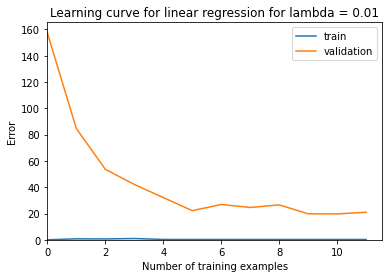

In [409]:
error_train, error_val = random_learning_curve(X_poly, y, X_val_poly, yval, _lambda = 0.01, avg_num = 250)

plt.plot(error_train, label='train')
plt.plot(error_val, label='validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('Learning curve for linear regression for lambda = 0.01')
plt.xlim(0, )
plt.ylim(0, )
plt.legend()
plt.show()